In [1]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset, LandmarkWaveletDataset
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

pd.set_option('mode.chained_assignment', None)
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

In [3]:
data_root = Path('/home/orel/Storage/Data/K7')

landmark_files = list(data_root.glob('2020-*/Down/*DeepCut*.h5'))
landmark_files

[PosixPath('/home/orel/Storage/Data/K7/2020-08-10/Down/0041DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-04/Down/0037DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-16/Down/0047DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-12/Down/0044DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-13/Down/0045DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-06/Down/0039DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-05/Down/0038DeepCut_resnet50_allFeb7shuffle1_1030000.h5')]

In [5]:
from simple_autoencoder import Autoencoder, PLAutoencoder
from dataloader import LandmarksDataModule
seqlen = 60
to_drop = ['head', 'forepawR2', 'forePawL2', 'chest1', 'chest2', 'belly1', 'belly2', 'hindpawR2', 
           'hindpawR3', 'hindpawL2', 'hindpawL3', 'tail1', 'tail2','tail3']
dm = LandmarksDataModule(landmark_files, seqlen=seqlen, step=1, to_drop=to_drop)
dm.prepare_data()
model = PLAutoencoder(landmark_files, n_neurons=[2*n_parts*seqlen, 1024, 512, 10], lr=5e-4, patience=20)
model.load_state_dict(torch.load('models/04_27_0/model.pt'))

<All keys matched successfully>

In [19]:
['head', 'forepawR2', 'forePawL2', 'chest1', 'chest2', 'belly1', 'belly2', 'hindpawR2', 
 'hindpawR3', 'hindpawL2', 'hindpawL3', 'tail1', 'tail2','tail3']

['nose',
 'head',
 'forepawR1',
 'forepawR2',
 'forePawL1',
 'forePawL2',
 'chest1',
 'chest2',
 'belly1',
 'belly2',
 'hindpawR1',
 'hindpawR2',
 'hindpawR3',
 'hindpawL1',
 'hindpawL2',
 'hindpawL3',
 'tailbase',
 'tail1',
 'tail3']

In [6]:
from scipy import signal as sig
energies = np.zeros(len(dm.all_ds))
for i, item in enumerate(dm.all_ds):
    item = item.reshape((dm.seqlen, -1))
    ff, Pxx = sig.periodogram(item.T, fs=dm.fps)
    energies[i] = Pxx.T[:10].mean()

1

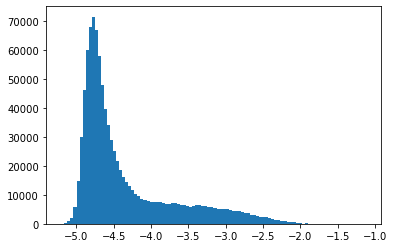

In [7]:
plt.hist(np.log10(energies), bins=100)
1
# selected_idxs = np.where(energies > 1e-7)[0]
# idx2orig = {idx : i for i, idx in enumerate(selected_idxs)}

In [10]:
selected_idxs

array([     0,      1,      2, ..., 961664, 961665, 961666])

In [11]:
X_encoded = model.model.encode(dm.all_ds)
selected_idxs = np.where(energies > 5e-5)[0]
# idx2orig = {idx : i for i, idx in enumerate(selected_idxs)}
K = model.model.encoder[-1].out_features
kmeans = KMeans(K)
labels = kmeans.fit_predict(X_encoded[selected_idxs])
_labels = np.zeros(len(X_encoded), dtype=np.int32) - 2
for i, lbl in enumerate(labels):
    _labels[selected_idxs[i]] = lbl
labels = _labels

In [12]:
import dataloader

labels_dict = {}
for df in dm.raw_data:
    labels_dict[df.attrs['file']] = np.zeros(len(df), dtype=np.int32) - 1

for idx, lbl in enumerate(labels):
    ds_id, _ = dataloader.find_sub_dataset_idx(dm.all_ds, idx)
    _, frame_idxs = dataloader.find_frame(dm.all_ds, idx)
    labels_dict[dm.raw_data[ds_id].attrs['file']][frame_idxs] = lbl

for df in dm.raw_data:
    df['label'] = labels_dict[df.attrs['file']]
    
segments_dict = {}
for file, labels in labels_dict.items():
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    split_at = np.append(np.zeros(1, dtype=np.int), np.where(np.diff(labels) != 0)[0] + 1)
    segments = [(split_at[i-1], split_at[i] - split_at[i-1],labels[split_at[i-1]]) for i in range(1, len(split_at))]
    segments = [seg for seg in segments if seg[-1] >= 0]
    segments = [seg for seg in segments if seg[1] >= 30]
    segments_dict[file] = segments

In [13]:
import cv2 as cv
import tkinter as tk
from triplets import landmarks_video, triplets_gui


def write_video(vid, file, fps):
    n_frames, width, height, _ = vid.shape
    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    writer = cv.VideoWriter(str(file), fourcc, fps, (height, width), True)
    for frame in vid:
        writer.write(frame)
    writer.release()


In [14]:
frame_to_time = lambda idx: f'{idx // (video.fps*60)}_{(idx % (video.fps*60)) // video.fps}'

cluster_dir = Path("/home/orel/Storage/shuki/projects/clusters/27_04_6")
os.makedirs(cluster_dir, exist_ok=True)
for file in dm.landmark_files:
    video = landmarks_video.LandmarksVideo(file.parent)
    file_id = file.name[:4]
    segments = segments_dict[file]
    for start_frame, n_frames, lbl in segments:
        mid_frame = start_frame + n_frames // 2
        n_frames = min(120 * 2, n_frames)
        start, end = mid_frame - n_frames // 2 , mid_frame + n_frames // 2
        save_dir = cluster_dir / f'{lbl}'
        os.makedirs(save_dir, exist_ok=True)
        clip = video[start: end: 2]
        video_file_name = f'{file_id}_{frame_to_time(mid_frame)}.avi'
        write_video(clip, save_dir / video_file_name, fps=24)

In [1]:
cluster_label = 3
cluster_segments = [seg for seg in segments_dict[file] if seg[2] == cluster_label]

root = tk.Tk()
for i in range(3):
    segment = cluster_segments[i]
    segment_clip = video[segment[0]: segment[0] + segment[1]:2]
    triplets_gui.Animation(root, frames=segment_clip, fps=60)
root.mainloop()

NameError: name 'segments_dict' is not defined